## Setup

In [1]:
# Things which have been upgraded/downgraded for reference
# You only need to install these once!

# !pip install matplotlib # Wasn't installed initially
# !pip install xgboost # Wasn't installed initially
# !pip install uproot # Wasn't installed initially
# !pip install uproot==3.13.1 # Has been downgraded because pandas data frames weren't working 

In [2]:
import sys

sys.path.insert(0, 'backend_functions')

import selection_functions as sf

import importlib

import uproot
import matplotlib.pylab as pylab
import numpy as np
import math
from sklearn.model_selection import train_test_split
import pickle
import xgboost as xgb

import awkward
import matplotlib.pyplot as plt
import pandas as pd

import ROOT
from ROOT import TH1F, TH2F, TDirectory, TH1D

# Top is where parameters(ISRUN3) is defined!
import top 
from top import *

importlib.reload(sf)
from selection_functions import *


Welcome to JupyROOT 6.26/10


In [3]:
ISRUN3 = False
NUE_INTRINSIC = True

In [4]:
plots_path = parameters(ISRUN3)['plots_path']
plots_path

'/Users/abarnard/phd/ccnp/uBNuMI_CC1eNp/plots/fhc/'

In [5]:
fold = "nuselection"
tree = "NeutrinoSelectionFilter"

DATA = ""
EXT = ""
OVRLY  = ""
DRT = ""
NUE = ""

path = parameters(ISRUN3)['cv_ntuple_path']
print('path = ', path)

if not ISRUN3: 

    # Run 1 FHC 
    OVRLY = 'neutrinoselection_filt_run1_overlay_v7'
    EXT = 'neutrinoselection_filt_run1_beamoff_v5'
    DATA = 'neutrinoselection_filt_run1_beamon_beamgood_v5'
    DRT = 'prodgenie_numi_uboone_overlay_dirt_fhc_mcc9_run1_v28_all_snapshot'
    
    if NUE_INTRINSIC: 
        NUE = 'neutrinoselection_filt_run1_overlay_intrinsic_v7' 


else: 
 
    # Run 3 RHC
    OVRLY = 'neutrinoselection_filt_run3b_overlay_v7'
    DATA = 'neutrinoselection_filt_run3b_beamon_beamgood_v5'
    EXT = 'neutrinoselection_filt_run3b_beamoff_v5'
    DRT = 'neutrinoselection_filt_run3b_dirt_overlay_v6'
    
    if NUE_INTRINSIC: 
        NUE = 'neutrinoselection_filt_run3b_overlay_intrinsic_v7'


path =  /Users/abarnard/phd/pelee_ntuples/run1/slimmed/


In [6]:

overlay = uproot.open(path+OVRLY+".root")[fold][tree]
# overlay = uproot.open("/exp/uboone/data/users/abarnard/pelee_ntuples/run_1/updated_run_1/slimmed/numi_nu_run1_slimmed.root")[fold][tree]
# overlay = uproot.open("/exp/uboone/data/users/abarnard/pelee_ntuples/run_3/updated_run_3/slimmed/numi_nu_run3_slimmed.root")[fold][tree]

# overlay = uproot.open("/exp/uboone/data/users/abarnard/pelee_ntuples/run_3/ar_run_3/slimmed/Run3_Nu_Overlay_NuMI_DL_Vertexing_ntuple_ntuple_ana_slimmed.root")[fold][tree]
# overlay = uproot.open("/exp/uboone/data/users/abarnard/pelee_ntuples/run_3/ar_run_3/slimmed/Run3_Nu_Overlay_NuMI_DL_Vertexing_WithShower_ntuple_ntuple_ana_slimmed.root")[fold][tree]

data = uproot.open(path+DATA+".root")[fold][tree]
ext = uproot.open(path+EXT+".root")[fold][tree]
dirt = uproot.open(path+DRT+".root")[fold][tree]  

uproot_v = [overlay,data,ext,dirt]

if NUE_INTRINSIC: 
    nue = uproot.open(path+NUE+".root")[fold][tree]
    # nue = uproot.open("/exp/uboone/data/users/abarnard/pelee_ntuples/run_1/updated_run_1/slimmed/numi_nue_run1_slimmed.root")[fold][tree]
    # nue = uproot.open("/exp/uboone/data/users/abarnard/pelee_ntuples/run_3/updated_run_3/slimmed/numi_nue_run3_slimmed.root")[fold][tree]
    
    # nue = uproot.open("/exp/uboone/data/users/abarnard/pelee_ntuples/run_3/ar_run_3/slimmed/Run3_Intrinsic_Nue_Overlay_NuMI_DL_Vertexing_ntuple_ntuple_ana_slimmed.root")[fold][tree]
    # nue = uproot.open("/exp/uboone/data/users/abarnard/pelee_ntuples/run_3/ar_run_3/slimmed/Run3_Intrinsic_Nue_Overlay_NuMI_DL_Vertexing_WithShower_ntuple_ntuple_ana_slimmed.root")[fold][tree]
    uproot_v.append(nue)


In [7]:
variables = [
    "trk_score_v", 
    "shr_tkfit_dedx_Y", 
    "n_tracks_contained", 
    "NeutrinoEnergy2",
    "run","sub","evt",
    "reco_nu_vtx_sce_x","reco_nu_vtx_sce_y","reco_nu_vtx_sce_z",
    "shrsubclusters0","shrsubclusters1","shrsubclusters2",
    "trkshrhitdist2",
    "n_showers_contained", 
    "shr_phi", "trk_phi", "trk_theta",
    "shr_score", 
    "trk_energy", 
    "tksh_distance", "tksh_angle",
    "shr_energy_tot_cali", "shr_energy_cali", 
    "nslice", 
    "contained_fraction",
    "shrmoliereavg", "shr_px", "shr_py", "shr_pz","swtrig_pre"
]

# MC only variables
mc_var = ["nu_pdg", "shr_theta", "true_e_visible", "ccnc", "interaction", 
          "nproton", "nu_e", "npi0", "npion",
          "true_nu_vtx_x", "true_nu_vtx_y" , "true_nu_vtx_z", 
          "weightTune", "weightSpline", "weightSplineTimesTune", 
          "true_nu_px", "true_nu_py", "true_nu_pz", 
          "elec_e", "proton_e", "mc_px", "mc_py", "mc_pz", "elec_px", "elec_py", "elec_pz", 
           "ppfx_cv", "mc_pdg", "opening_angle"]


## Create pandas dataframes

In [8]:
# OVERLAY 
overlay = overlay.pandas.df(variables + mc_var, flatten=False)

In [9]:
# DIRT 
dirt = dirt.pandas.df(variables + mc_var, flatten=False)

In [10]:
# INTRINSIC 
if NUE_INTRINSIC: 
    nue = nue.pandas.df(variables + mc_var, flatten=False)

In [11]:
# BEAM ON 
data = data.pandas.df(variables, flatten=False) 

In [12]:
# BEAM OFF
ext = ext.pandas.df(variables, flatten=False)

In [13]:
# equalize the columns

for var in mc_var: 
    data[var] = np.nan
    ext[var] = np.nan

In [14]:
# is dirt bool

overlay['isDirt'] = False
dirt['isDirt'] = True

if NUE_INTRINSIC: 
    nue['isDirt'] = False
    
data['isDirt'] = np.nan
ext['isDirt'] = np.nan

In [15]:
# how to get the LLR-PID value for the "track candidate" (proton for nue selection, muon for numu)
# code from Giuseppe!
#LLR-PID : log-likelihood ratio particle ID 

df_v = [overlay,data,ext,dirt]

if NUE_INTRINSIC: 
    df_v.append(nue)
    
for i,df in enumerate(df_v):
    up = uproot_v[i]
    trk_llr_pid_v = up.array('trk_llr_pid_score_v')
    trk_id = up.array('trk_id')-1 # I think we need this -1 to get the right result
    trk_llr_pid_v_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_llr_pid_v,trk_id)])
    df['trkpid'] = trk_llr_pid_v_sel
    df['subcluster'] = df['shrsubclusters0'] + df['shrsubclusters1'] + df['shrsubclusters2']

    df['NeutrinoEnergy2_GeV'] = df['NeutrinoEnergy2']/1000
    # df['shr_energy_cali'] = df['shr_energy_cali']/0.83


In [16]:
overlay = overlay.query('swtrig_pre==1')
dirt = dirt.query('swtrig_pre==1')
nue = nue.query('swtrig_pre==1')

In [17]:
mc_df = [overlay, dirt]

if NUE_INTRINSIC: 
    mc_df.append(nue)

In [18]:
for i,df in enumerate(mc_df):
    
    # is signal bool 
    df['is_signal'] = np.where((df.swtrig_pre == 1) 
                             & (df.nu_pdg==12) & (df.ccnc==0) & (df.nproton>0) & (df.npion==0) & (df.npi0==0)
                             & (10 <= df.true_nu_vtx_x) & (df.true_nu_vtx_x <= 246)
                             & (-106 <= df.true_nu_vtx_y) & (df.true_nu_vtx_y <= 106)
                             & (10 <= df.true_nu_vtx_z) & (df.true_nu_vtx_z <= 1026), True, False)
    
    # Add truth level theta & phi angles (detector & beam coordinates)
    df = addAngles(df)


/var/folders/pj/m9tfv03972l1ccvgzxkhhrdh0000gq/T/ipykernel_34626/3255934275.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['is_signal'] = np.where((df.swtrig_pre == 1)
/Users/abarnard/phd/ccnp/uBNuMI_CC1eNp/backend_functions/top.py:740: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['thdet'] = np.arctan2(((df['true_nu_px']*df['true_nu_px'])+(df['true_nu_py']*df['true_nu_py']))**(1/2), df['true_nu_pz'])*(180/math.pi)
/Users/abarnard/phd/ccnp/uBNuMI_CC1eNp/backend_functions/top.py:741: SettingWithCo

In [19]:
# corrected visible energy variable - account for electrons below 30 MeV 
# use this variable for the visible energy unfolding 

visible_energy_nothres(overlay)
visible_energy_nothres(dirt)

/Users/abarnard/phd/ccnp/uBNuMI_CC1eNp/backend_functions/top.py:410: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['elec_ke'] = df.elec_e - 0.000511
/Users/abarnard/phd/ccnp/uBNuMI_CC1eNp/backend_functions/top.py:426: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['true_e_visible2'] = E_vis_new
/Users/abarnard/phd/ccnp/uBNuMI_CC1eNp/backend_functions/top.py:410: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

In [20]:
# make dataframes equal # of columns 

data['is_signal'] = np.nan
ext['is_signal'] = False

nan_var = ['thdet', 'phidet', 'true_nu_px_beam', 'true_nu_py_beam', 'true_nu_pz_beam', 
           'thbeam', 'phibeam', 'true_e_visible2']

for var in mc_var+nan_var: 
    data[var] = np.nan
    ext[var] = np.nan

In [21]:
# some checks 
print(len(nue.query('is_signal==True'))==len(nue.query(signal)))
print(len(nue.query('is_signal==False'))==len(nue.query(not_signal)))

True
True


## Weights

In [22]:
# clean bad weights & values 

for i,df in enumerate(mc_df):
     
    df.loc[ df['weightSplineTimesTune'] <= 0, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] == np.inf, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] > 100, 'weightSplineTimesTune' ] = 1.
    df.loc[ np.isnan(df['weightSplineTimesTune']) == True, 'weightSplineTimesTune' ] = 1.
    
    df.loc[ df['weightTune'] <= 0, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] == np.inf, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] > 100, 'weightTune' ] = 1.
    df.loc[ np.isnan(df['weightTune']) == True, 'weightTune' ] = 1.  

        

In [23]:
# POT normalization

beamon_pot = parameters(ISRUN3)['beamon_pot'] 

overlay = pot_scale(overlay, 'overlay', ISRUN3)
dirt = pot_scale(dirt, 'dirt', ISRUN3)
ext = pot_scale(ext, 'ext', ISRUN3)

if NUE_INTRINSIC: 
    nue = pot_scale(nue, 'intrinsic', ISRUN3)

data['pot_scale'] = [1 for x in range(len(data))]



Adding pot_scale column using dirt & EXT tune....
Adding pot_scale column using dirt & EXT tune....
Adding pot_scale column using dirt & EXT tune....
Adding pot_scale column using dirt & EXT tune....


In [24]:
# combined genie * POT weight * flux weight , ext gets POT weight only 
################################################################
# totweight_data scales to BEAMON

# tuned
overlay['totweight_data'] = overlay['pot_scale']#*overlay['ppfx_cv']*overlay['weightSplineTimesTune']
dirt['totweight_data'] = dirt['pot_scale']#*dirt['ppfx_cv']*dirt['weightSplineTimesTune']

if NUE_INTRINSIC: 
    nue['totweight_data'] = nue['pot_scale']#*nue['ppfx_cv']*nue['weightSplineTimesTune']

ext['totweight_data'] = np.nan
data['totweight_data'] = np.nan


In [25]:
ISRUN3

False

## Categories

In [26]:
# replace nue CC events with intrinsic sample

if NUE_INTRINSIC: 
    
    print("# of nueCC in AV in overlay sample = "+str(len(overlay.query(nueCC_query))))
    len1 = len(overlay)
    
    idx = overlay.query(nueCC_query).index
    overlay.drop(idx, inplace=True)
    len2 = len(overlay) 
    print("# of nueCC in AV dropped in overlay = "+str(len1-len2))
    
    overlay = pd.concat([overlay,nue], ignore_index=True)


# of nueCC in AV in overlay sample = 6163
# of nueCC in AV dropped in overlay = 6163


In [27]:
# combine overlay + dirt as MC 

mc = pd.concat([overlay.query('swtrig_pre==1'),dirt.query('swtrig_pre==1')], ignore_index=True, sort=True)

infv = mc.query(in_fv_query)
outfv = mc.query(out_fv_query)

In [28]:

# check that everything is accounted for 
print(len(mc)==len(infv)+len(outfv))

if not (len(mc)==len(infv)+len(outfv)): 
    
    d = len(mc) - (len(infv)+len(outfv))
    print(d)
    
    m = pd.concat([infv, outfv])
    diff = np.setdiff1d(list(mc.index),list(m.index))


True


In [29]:
tot_signal_weighted = np.nansum(mc.query('is_signal==True')['totweight_data'])
print('total signal events = '+ str(tot_signal_weighted))


total signal events = 269.2929531482784


In [30]:
# 5 main categories: 

# infv - overlay/dirt events with truth vtx in FV 
# outfv - overlay/dirt events with truth vtx in FV that are classified as neutrinos
# cosmic - overlay/dirt events with true vtx in FV that get misclassified as cosmic 
# ext - beam OFF data
# data - beam ON data 


datasets = {
    "infv": infv, 
    "outfv": outfv, 
    "ext": ext, 
    "data": data
}


# Linear selection

In [31]:
# PRESELECTION

PRE_QUERY = 'swtrig_pre==1 and nslice==1' # 
PRE_QUERY += ' and ' + reco_in_fv_query 
PRE_QUERY += ' and contained_fraction>0.9' 

PRE_QUERY += ' and n_showers_contained == 1'
PRE_QUERY += ' and n_tracks_contained>0'
PRE_QUERY += ' and trk_energy>0.04' 


In [ ]:
# new optimized selection by Kaushal 

SEL_QUERY = PRE_QUERY

SEL_QUERY += ' and shr_score<0.125'
SEL_QUERY += ' and shrmoliereavg<8'
SEL_QUERY += ' and trkpid<0'

SEL_QUERY += ' and shr_tkfit_dedx_Y<4'

if not ISRUN3: 
    SEL_QUERY += ' and tksh_distance<5'

else: 
    SEL_QUERY += ' and tksh_distance<4'

# BDT Selection

In [33]:
# load bdt model 
split = 1
bdt_model = xgb.Booster({'nthread': 4})
bdt_model.load_model(parameters(ISRUN3)['bdt_model'])
    
datasets_bdt = {}

for i in range(len(datasets)): 

    df = list(datasets.values())[i].copy()
    df = df.query(BDT_LOOSE_CUTS)

    # clean datasets 
    for column in training_parameters:
        df.loc[(df[column] < -1.0e37) | (df[column] > 1.0e37), column] = np.nan

    # create testing dmatrix 
    df_test = xgb.DMatrix(data=df[training_parameters])

    # apply the bdt selection
    preds = bdt_model.predict(df_test)

    # add columns for plotting 
    df['BDT_score'] = preds

    datasets_bdt[list(datasets.keys())[i]] = df
    

/Users/abarnard/miniforge3/envs/ccnpenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:49:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1070: Loading model from XGBoost < 1.0.0, consider saving it again for improved compatibility
  warnings.warn(smsg, UserWarning)


In [34]:
bdt_score_cut = parameters(ISRUN3)['bdt_score_cut']
    
print("BDT SCORE THRESHOLD = "+str(bdt_score_cut))

selected_query = BDT_LOOSE_CUTS + ' and BDT_score>'+str(bdt_score_cut)
selected_signal_query = selected_query + ' and is_signal==True'


BDT SCORE THRESHOLD = 0.55


In [35]:
datasets_bdt['outfv'].nu_e

99        1.415573
449       1.655776
608       1.483465
726       0.933393
786       3.018628
            ...   
170739    1.836550
170936    2.065241
170963    1.010576
171031    6.267282
171139    2.983105
Name: nu_e, Length: 801, dtype: float32

In [36]:
print("GENERATED SIGNAL (DATA NORMALIZED) = "+str(sum(generated_signal(ISRUN3, 'nu_e', [0,20], 0, 20, weight='totweight_data')[0])))


Adding pot_scale column using dirt & EXT tune....
GENERATED SIGNAL (DATA NORMALIZED) = 434.69095051036595


total selected = 313.69604124191505


/Users/abarnard/phd/ccnp/uBNuMI_CC1eNp/backend_functions/selection_functions.py:379: RuntimeWarning: invalid value encountered in divide
  ext_percent_err = np.sqrt(ext_counts)/n[-1]
/Users/abarnard/phd/ccnp/uBNuMI_CC1eNp/backend_functions/selection_functions.py:380: RuntimeWarning: invalid value encountered in divide
  mc_percent_err = mc_err/n[-1]


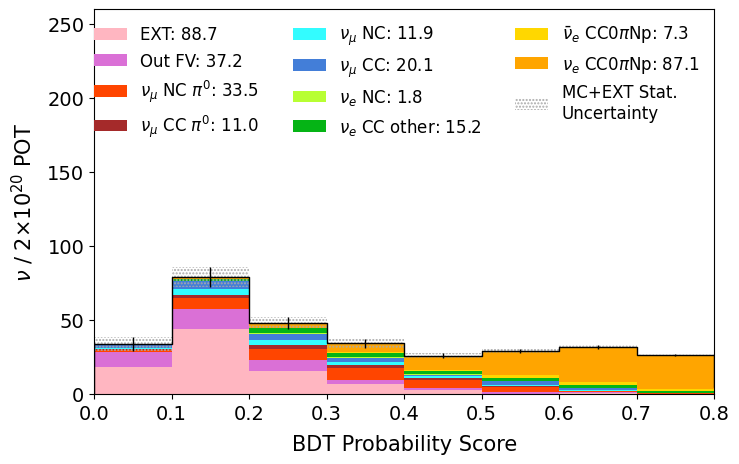

In [37]:
# BDT score output 

x = plot_mc('BDT_score', [round(x*0.1, 2) for x in range(11)], 0, 1, BDT_LOOSE_CUTS, 
            datasets_bdt, ISRUN3, x_label="BDT Probability Score", 
            norm='data', y_label='$\\nu$ / 2$\\times10^{20}$ POT', sys=None, plot_bkgd=False, save= False, xmax=0.8, ymax=260)#, ymax=100)

### Performance 

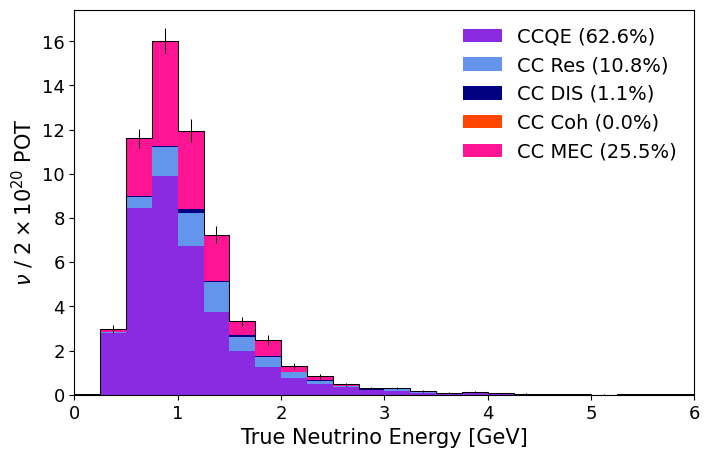

In [38]:
int_labels = {
    '0': 'CCQE', 
    '1': 'CC Res', 
    '2': 'CC DIS', 
    '3': 'CC Coh', 
    '10': 'CC MEC' 
}

fig = plt.figure(figsize=(8, 5))

xvar = 'nu_e'

ccqe = datasets_bdt['infv'].query(selected_signal_query+' and interaction==0')
ccres = datasets_bdt['infv'].query(selected_signal_query+' and interaction==1')
ccdis = datasets_bdt['infv'].query(selected_signal_query+' and interaction==2')
cccoh = datasets_bdt['infv'].query(selected_signal_query+' and interaction==3')
ccmec = datasets_bdt['infv'].query(selected_signal_query+' and interaction==10')

int_weights = [ccqe['totweight_data'], 
                 ccres['totweight_data'], 
                 ccdis['totweight_data'], 
                 cccoh['totweight_data'], 
                 ccmec['totweight_data']]

int_counts = []
for l in int_weights: 
    int_counts.append( np.nansum(l) )
    
tot_count = sum(int_counts)
int_counts = [str(round((x/tot_count)*100, 1)) for x in int_counts]

# signal broken down by interactions after the selection 
n, b, p = plt.hist([ccqe[xvar], ccres[xvar], ccdis[xvar], cccoh[xvar], ccmec[xvar]],
          [x*0.25 for x in range(25)], 
          weights=int_weights,
          label=[int_labels['0']+' ('+int_counts[0]+'%)', 
                 int_labels['1']+' ('+int_counts[1]+'%)', 
                 int_labels['2']+' ('+int_counts[2]+'%)', 
                 int_labels['3']+' ('+int_counts[3]+'%)', 
                 int_labels['10']+' ('+int_counts[4]+'%)'],
          color=[ 'blueviolet','cornflowerblue','navy',  'orangered', 'deeppink'], # Change colours here!
          stacked=True)

bincenters = 0.5*(b[1:]+b[:-1])

y_err = mc_error(xvar, b, b[0], b[-1], [datasets_bdt['infv'].query(selected_signal_query)])
#y_err = [x*y for x, y in zip(n[-1], signal_percent_err)]

plt.hist(bincenters, b, color='black', linewidth=0.75, weights=n[-1], histtype='step')
plt.errorbar(bincenters, n[-1], yerr=y_err,
             color='black', linewidth=.75, fmt='none')#, alpha=.7)

plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

plt.xlabel("True Neutrino Energy [GeV]", fontsize=15)
plt.ylabel('$\\nu$ / $2\\times10^{20}$ POT', fontsize=15)
#plt.title('FHC RUN 1 Selected Event Rate', fontsize=16)

plt.legend(frameon=False, fontsize=14)

plt.xlim(0, 6)

#plt.savefig("/uboone/app/users/abarnard/katrina_analysis/code/uBNuMI_CC1eNp/FHCSelectedInteractions.pdf", transparent=True, bbox_inches='tight') 

#plt.savefig(parameters(ISRUN3)['plots_path']+"FHCSelectedInteractions.pdf", transparent=True, bbox_inches='tight') 

plt.show()

In [39]:
q = BDT_LOOSE_CUTS+' and BDT_score>'+str(bdt_score_cut)
q

'swtrig_pre==1 and nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_showers_contained==1 and n_tracks_contained>0 and trk_energy>0.04 and shr_score<0.3 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and trkpid<0.35 and tksh_distance<12 and BDT_score>0.55'

In [40]:
useBDT = True

if useBDT: 
    datasets_dict = datasets_bdt
else: 
    datasets_dict = datasets

In [ ]:

tot_sig_sel = np.nansum(datasets_dict['infv'].query(q+' and is_signal==True').totweight_data)
tot_sel = np.nansum(datasets_dict['infv'].query(q).totweight_data) + np.nansum(datasets_dict['outfv'].query(q).totweight_data) + np.nansum(datasets_dict['ext'].query(q).pot_scale)
tot_sig = sum(generated_signal(ISRUN3, 'nu_e', [0,100], 0, 100)[0])

print("Purity = ", tot_sig_sel/tot_sel)
print("Efficiency = ", tot_sig_sel/tot_sig)


In [ ]:
datasets_dict['infv'].query(q+' and is_signal==True')["shr_energy_cali"].min()

In [ ]:
datasets_dict['data'].query(q)["shr_energy_cali"].min()

## BDT Training

In [ ]:
TRAIN = False
save_bdt = False

In [ ]:

# TRAIN ON A SUBSET OF THE DISTRIBUTION
train_query = BDT_LOOSE_CUTS + ' and -0.9<tksh_angle<0.9 and shr_energy_tot_cali>0.07'
test_query = BDT_LOOSE_CUTS


In [ ]:
# subset distributions 

x = plot_mc('tksh_angle', [-1, -.9, -.8, -.7, -.6, -.5, -.4, -.3, -.2, -.1] + list(round(x*0.1,2) for x in range(11)), 
        -1, 1, test_query, datasets, ISRUN3, norm='data')
        #save=False, save_label='RHCRUN3_loosecuts_mconly', log=False, x_label='$cos(\\theta_{ep})$',
        #text='FHC RUN 1', xtext=0.75, ytext=70)

x = plot_mc('shr_energy_tot_cali', list(x*0.01 for x in range(21)), 
        0, 0.2, test_query, datasets, ISRUN3, norm='data', ymax=65)
        #save=False, save_label='RHCRUN3_loosecuts_mconly', log=False, x_label='Total Calibrated Shower Energy [GeV]', 
        #text='FHC RUN 1', xtext=0.19, ytext=35)




In [ ]:
df_pre = addRelevantColumns(datasets) # includes both MC and EXT 

In [ ]:
total_signal_generated = sum(generated_signal(ISRUN3, 'nu_e', [0,100], 0, 100)[0])
print(total_signal_generated)

In [ ]:
total_signal_generated_intrinsic = sum(generated_signal(ISRUN3, 'nu_e', [0,100], 0, 100, weight='totweight_intrinsic')[0])
print(total_signal_generated_intrinsic)

#### Pre BDT performance as a function of test sample size 

In [ ]:
# efficiency of total sample 
e_total = sum(df_pre.query(test_query+ ' and is_signal==True')['weight']) / total_signal_generated 

# efficiency error - binomial (use the intrinsic event count)
e_total_err = np.sqrt(e_total * (1-e_total) / total_signal_generated_intrinsic) * 100 

# purity of total sample 
p_total = sum(df_pre.query(test_query+ ' and is_signal==True')['weight']) / sum(df_pre.query(test_query)['weight'])

# purity error - poissonian 
p_total_err = (p_total * np.sqrt( sum(df_pre.query(test_query+' and is_signal==True').weight**2)/(sum(df_pre.query(test_query+' and is_signal==True').weight)**2) + sum(df_pre.query(test_query).weight**2)/(sum(df_pre.query(test_query).weight)**2) )) * 100

e_total = e_total*100
p_total = p_total*100


# store efficiency & purity values
e = []
e_err = []

p = []
p_err = []

xpoints = [round(i*0.05, 2) for i in range(20)]

for test_size in xpoints[1:]: 

    df_pre_train, df_pre_test = train_test_split(df_pre, test_size=test_size, 
                                             random_state=17, stratify=df_pre['is_signal'])
    
    total_signal_selected = sum(df_pre_test.query(test_query+ ' and is_signal==True')['weight'])
    total_selected = sum(df_pre_test.query(test_query)['weight'])
    
    eff = total_signal_selected / (total_signal_generated*test_size) 
    pur = total_signal_selected / total_selected
    
    e.append(eff*100)
    p.append(pur*100)
    
    e_err.append( np.sqrt( (eff*(1-eff)) / (total_signal_generated_intrinsic*test_size) ) * 100) # use the intrinsic event count
    p_err.append( (pur * np.sqrt( sum(df_pre_test.query(test_query+' and is_signal==True').weight**2)/sum(df_pre_test.query(test_query+' and is_signal==True').weight)**2 + sum(df_pre_test.query(test_query).weight**2)/sum(df_pre_test.query(test_query).weight)**2) )*100 ) 
                 

In [ ]:

plt.figure(figsize=(7.5, 5))

plt.errorbar(xpoints[1:], p, yerr=p_err, label="Purity (Test Sample)", color='firebrick', marker='.')
plt.axhline(y=p_total, label="Purity (Full)", color='firebrick', linewidth=1, linestyle="--")

plt.fill_between(xpoints, p_total-p_total_err, p_total+p_total_err, color='firebrick', alpha=0.1)


plt.ylim(15, 30)
plt.xlim(xpoints[0], xpoints[-1])
plt.grid(linestyle=':')
plt.legend(fontsize=13, ncol=2)

plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

plt.xlabel('Test Sample Size (Relative to Full Sample)', fontsize=14)
plt.ylabel('Performance (%)', fontsize=14)

if ISRUN3: 
    plt.title('RHC Run 3 Pre-BDT Purity', fontsize=15)
#    plt.savefig(parameters(ISRUN3)['plots_path']+"RHCStratPerf_Purity.pdf", transparent=True, bbox_inches='tight') 
else: 
    plt.title('FHC Run 1 Pre-BDT Efficiency', fontsize=15)
#    plt.savefig(parameters(ISRUN3)['plots_path']+"FHCStratPerf_Purity.pdf", transparent=True, bbox_inches='tight') 


plt.show()



In [ ]:

plt.figure(figsize=(7.5, 5))

plt.errorbar(xpoints[1:], e, yerr=e_err, label="Efficiency (Test Sample)", color='seagreen', marker='.')
plt.axhline(y=e_total, label="Efficiency (Full)", color='seagreen', linewidth=1, linestyle="--")

plt.fill_between(xpoints, e_total-e_total_err, e_total+e_total_err, color='seagreen', alpha=0.1)


plt.ylim(15, 30)
plt.xlim(xpoints[0], xpoints[-1])
plt.grid(linestyle=':')
plt.legend(fontsize=13, ncol=2)

plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

plt.xlabel('Test Sample Size (Relative to Full Sample)', fontsize=14)
plt.ylabel('Performance (%)', fontsize=14)

if ISRUN3: 
    plt.title('RHC Run 3 Pre-BDT Efficiency', fontsize=15)
    #plt.savefig(parameters(ISRUN3)['plots_path']+"RHCStratPerf_Efficiency.pdf", transparent=True, bbox_inches='tight') 
else: 
    plt.title('FHC Run 1 Pre-BDT Efficiency', fontsize=15)
    #plt.savefig(parameters(ISRUN3)['plots_path']+"FHCStratPerf_Efficiency.pdf", transparent=True, bbox_inches='tight') 

plt.show()

#### AUC & AUCPR Metrics

In [ ]:
final_test_size = 0.5

In [ ]:
# Check the boosting rounds 

# Split arrays or matrices into random train and test subsets
df_pre_train, df_pre_test = train_test_split(df_pre, test_size=final_test_size, 
                                             random_state=17, stratify=df_pre['is_signal'])

bdt_metrics(df_pre_train, df_pre_test, train_query, test_query, 
            training_parameters, ISRUN3, save=False, verbose=False)

#### Create new BDT model 

In [ ]:
# pre-determined boosting round numbers

if not ISRUN3: # FHC
    lc_rounds = 200
    
else: # RHC
    lc_rounds = 150

#test train split 
split = final_test_size
print('split', split)


In [ ]:
if TRAIN: 
    
    # BDT training - backend function cleans the dataset first 
    bdt_lc = main_BDT(datasets, train_query, test_query, lc_rounds, training_parameters, ISRUN3, test_size=split)

    results_df = bdt_lc['bdt_results_df']
    bdt_model = bdt_lc['bdt_model']
    train_df = bdt_lc['df_pre_train']
    test_df = bdt_lc['df_pre_test']
    
    # split events into different categories 
    datasets_bdt = split_events(results_df)

# note: all of the plots following be made with half the POT this way (test/train split)

In [ ]:
if save_bdt: 
    bdt_model.save_model('BDT_models/test_rhc_sept24.model') 
    # Path to change which BDT you use is in the top.py script!
    print('saving BDT...')

In [ ]:
if TRAIN: 

    # performance of the linear selection for comparison
    gen_split = total_signal_generated*split
    eff_box = np.nansum(test_df.query(SEL_QUERY+' and is_signal==1').weight)/gen_split * 100

    tot_sel = np.nansum(test_df.query(SEL_QUERY)['weight']) 
    pur_box = np.nansum(test_df.query(SEL_QUERY+' and is_signal==1').weight) / tot_sel * 100

    results_box = [pur_box, eff_box]

    #  stat errors on the linear performance 
    e = eff_box/100

    eff_err = math.sqrt( (e*(1-e)) / total_signal_generated_intrinsic*split ) * 100
    pur_err = pur_box * np.sqrt( sum(test_df.query(SEL_QUERY+' and is_signal==1').weight**2)/sum(test_df.query(SEL_QUERY+' and is_signal==1').weight)**2 + sum(test_df.query(SEL_QUERY).weight**2)/sum(test_df.query(SEL_QUERY).weight)**2 )

    results_box_err = [pur_err, eff_err]

    # x values
    x = np.arange(0, 0.8, 0.025)

    # returns purity, purErr, eff, effErr
    perf_dict = bdt_pe(results_df, x, 
                  total_signal_generated, total_signal_generated_intrinsic, split)
    pur, pur_err, eff, eff_err = perf_dict['purity'], perf_dict['purErr'], perf_dict['eff'], perf_dict['effErr']
    
    bdt_box_plot([pur, pur_err, eff, eff_err], x, ISRUN3, save=False, results_box=results_box, results_box_err=results_box_err)
    
    

In [ ]:
bdt_svb_plot(results_df)

In [ ]:
## apply bdt model to the entire dataset

split = 1

datasets_bdt_full = {}

for i in range(len(datasets)): 

    df = list(datasets.values())[i].copy()
    df = df.query(BDT_LOOSE_CUTS)

    # clean datasets 
    for column in training_parameters:
        df.loc[(df[column] < -1.0e37) | (df[column] > 1.0e37), column] = np.nan

    # create testing dmatrix 
    df_test = xgb.DMatrix(data=df[training_parameters])

    # apply the bdt selection
    preds = bdt_model.predict(df_test)

    # add columns for plotting 
    df['BDT_score'] = preds

    datasets_bdt_full[list(datasets.keys())[i]] = df
  

In [ ]:
datasets_bdt_full.keys()

datasets_bdt_full['infv']['weight'] = list(datasets_bdt_full['infv'].totweight_data)
datasets_bdt_full['outfv']['weight'] = list(datasets_bdt_full['outfv'].totweight_data)

datasets_bdt_full['ext']['weight'] = list(datasets_bdt_full['ext'].pot_scale)

In [ ]:
datasets_bdt_full['tot_sim'] = pd.concat([datasets_bdt_full['infv'], datasets_bdt_full['outfv'], datasets_bdt_full['ext']])

#### Cross validation 

In [ ]:
from sklearn.model_selection import RepeatedStratifiedKFold

In [ ]:

splits = 2
repeats = 20
cv = RepeatedStratifiedKFold(n_splits=splits, n_repeats=repeats, random_state=36851234)

if ISRUN3: 
    bdt_score_arr = np.arange(0, 0.75, 0.025)
    
else: 
    bdt_score_arr = np.arange(0, 0.8, 0.025)



In [ ]:
df_crossval = addRelevantColumns(datasets)

scale_weight = len(df_crossval.query(train_query + ' and is_signal == False')) / len(df_crossval.query(train_query + ' and is_signal == True'))
print("scale pos weight (ratio of negative to positive) = "+str(scale_weight))


In [ ]:
len(df_crossval.query(train_query + ' and is_signal == False'))

In [ ]:
#model params
params = {
        'objective': 'binary:logistic',
        'booster': 'gbtree',
        'eta': 0.02,
        'tree_method': 'exact',
        'max_depth': 3,
        'subsample': 0.8,
        'colsample_bytree': 1,
        'silent': 1,
        'min_child_weight': 1,
        'seed': 2002,
        'gamma': 1,
        'max_delta_step': 0,
        'scale_pos_weight': scale_weight,
        'eval_metric': ['error', 'auc', 'aucpr']
}

In [ ]:
final_purity = []
final_efficiency=[]

fp_err = []
fe_err = []

box_pur = []
box_eff = []

boxp_err = []
boxe_err = []

print('Note: must use 50/50 split for the cv.split function to work!')

for train_index, test_index in cv.split(df_crossval, df_crossval['is_signal']):
    
    train, test = df_crossval.iloc[train_index], df_crossval.iloc[test_index]    
    
    bdt_cv_lc = bdt_raw_results(train, test, train_query, test_query, training_parameters, params, lc_rounds)
    
    # saves purity, efficiency and respective errors on current test sample for loose cuts BDT
    perf = bdt_pe(bdt_cv_lc[0], bdt_score_arr, total_signal_generated, total_signal_generated_intrinsic, split)
    pur, pur_err, eff, eff_err = perf['purity'], perf['purErr'], perf['eff'], perf['effErr']
    
    final_purity.append(pur)
    final_efficiency.append(eff)
    
    fp_err.append(pur_err)
    fe_err.append(eff_err)

    # LINEAR SELECTION PERFORMANCE 
    
    sig_sel = sum(test.query(SEL_QUERY+' and is_signal==1').weight)
    tot_sel = sum(test.query(SEL_QUERY).weight)
    
    tot_sig = total_signal_generated*0.5
    tot_sig_intrinsic = total_signal_generated_intrinsic*0.5
    
    p = sig_sel / tot_sel
    e = sig_sel / tot_sig
    
    box_pur.append(p * 100)
    box_eff.append(e * 100)
        
    boxp_err.append( p * np.sqrt( sum(test.query(SEL_QUERY+' and is_signal==True').weight**2)/sum(test.query(SEL_QUERY+' and is_signal==True').weight)**2 + sum(test.query(SEL_QUERY).weight**2)/sum(test.query(SEL_QUERY).weight)**2 ) * 100)
    boxe_err.append(math.sqrt( (e * (1-e)) / tot_sig_intrinsic) * 100)

In [ ]:
# averages results column-wise, which is equivalent to averaging results over the same BDT_score cut

results_bdt = [np.mean(final_purity, axis=0), np.mean(fp_err, axis=0), 
               np.mean(final_efficiency, axis=0), np.mean(fe_err, axis=0)]

# linear box cut selection is a normal average over each distinct test sample
results_box = [np.mean(box_pur), np.mean(box_eff)]
results_box_err = [np.mean(boxp_err), np.mean(boxe_err)]

In [ ]:
for i in range(len(bdt_score_arr)): 
    if bdt_score_arr[i]>=0.45: 
        print("BDT score > "+str(round(bdt_score_arr[i], 3)))
        print("efficiency = "+str(round(results_bdt[2][i], 1)))
        print("purity = "+str(round(results_bdt[0][i], 1)))

In [ ]:
if ISRUN3: 
    title = "RHC Run 3 Cross Validation"
    save_label = "RHCRUN3_crossvalidation"
else: 
    title = "FHC Run 1 Cross Validation"
    save_label = "FHCRUN1_crossvalidation"

In [ ]:
bdt_box_plot(results_bdt, bdt_score_arr, ISRUN3, results_box=results_box, results_box_err=results_box_err, 
           save=False, save_label=save_label, title=title) 